In [1]:
from citalopram_project.load import load_spikes, load_neurons

neurons = load_neurons()
chal_spikes = load_spikes("chal").merge(neurons[["neuron_id", "cluster", "session_name", "group"]]).loc[lambda x: x.spiketimes <= 1200]


In [51]:
import functools
class Pipeline:

    def __init__(self, steps):
        self.funcs = [functools.partial(f, **kwargs) for f, kwargs in steps]
        self.func = functools.reduce(lambda f, g: lambda x: g(f(x)), self.funcs)
    
    def transform(self, df):
        return self.func(df)

In [52]:
import pandas as pd
from spiketimes.df.statistics import ifr_by
from scipy.stats import zmap, zscore
import numpy as np
import seaborn as sns
from spiketimes.utils import p_adjust

def split_by_group(df):
    return {gname: df.loc[lambda x: x.group == gname] for gname in df["group"].unique()}

def bin_spikes(df, binwidth, gaussian_sigma=None):
    return ifr_by(df, fs=1/binwidth, sigma=gaussian_sigma, spiketrain_col="neuron_id")

def pivot(df, time_col="time", value_col="ifr", neuron_col="neuron_id"):
    return pd.pivot(df, index=time_col, values=value_col, columns=neuron_col)

def standardize(df, baseline_before=None):
    def _standardize_col(col, baseline_before=None):
        if baseline_before is not None:
            return zmap(col, col.loc[lambda x: x.index < baseline_before])
        else:
            return zscore(col)
    return df.apply(_standardize_col, baseline_before=baseline_before)

def exclude_baseline(df, baseline_before=0, min_baseline_fr=0.2):
    idx = df.apply(lambda x: x.loc[x.index < baseline_before].mean() > min_baseline_fr).tolist()
    return df.loc[:, idx]

def round_index(df, precision=0):
    df.index = np.round(df.index, precision)
    return df

def select_neuron_type(df, neuron_df, neuron_type):
    neurons_of_interest = neuron_df.loc[lambda x: x.cluster == neuron_type].neuron_id.unique()
    return df.loc[:, [n for n in df.columns if n in neurons_of_interest]]

def sort_by_inhibition(df):
    idx = df.loc[lambda x: x.index > 0].min().sort_values().index.tolist()
    return df[idx]

In [53]:
pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=1, gaussian_sigma=1)),
        (pivot, dict()),
        (round_index, dict()),
        (exclude_baseline, dict(baseline_before=0.2)),
        (standardize, dict(baseline_before=0)),
        (select_neuron_type, dict(neuron_df=neurons, neuron_type="slow_regular")),
        (sort_by_inhibition, dict())
    ]
)

by_group = split_by_group(chal_spikes)
df =by_group["continuation"]
dfp = pipe.transform(df)
dfp.shape

(1800, 85)

<AxesSubplot:xlabel='time', ylabel='neuron_id'>

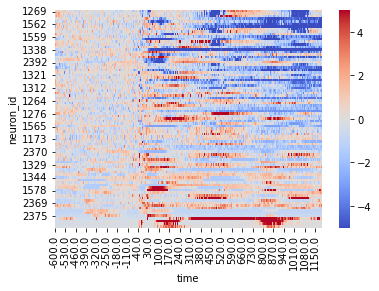

In [54]:
sns.heatmap(dfp.transpose(), vmin=-5, vmax=+5, cmap="coolwarm")

<AxesSubplot:xlabel='time', ylabel='neuron_id'>

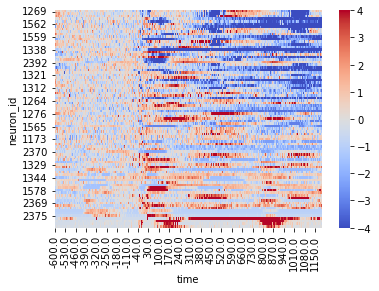

In [55]:
sns.heatmap(dfp.transpose(), vmin=-4, vmax=+4, cmap="coolwarm")

<AxesSubplot:xlabel='time', ylabel='neuron_id'>

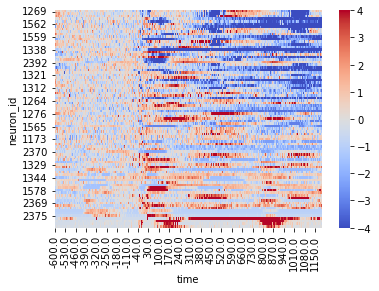

In [56]:
sns.heatmap(dfp.transpose(), vmin=-4, vmax=+4, cmap="coolwarm")

In [76]:
from ezbootstrap import permutation_2sample

def permutation_around_baseline(df, func, baseline_before=0, n_boot=1000, how="two_sided"):
        def _apply_around_col(col, baseline_before, func_, how, n_boot=n_boot):         
            x = col.loc[lambda x: x.index <=  baseline_before].values
            y = col.loc[lambda x: x.index >  baseline_before].values
            obs = func_(x, y)
            reps = permutation_2sample(x, y, func_, size=n_boot)
            if how == "two_sided":
                p = (np.abs(reps) >= np.abs(obs)).mean() * 2
            elif how == "lower":
                p = (reps <= obs).mean()
            elif how == "upper":
                p = (reps >= obs).mean()
            else:
                raise ValueError("Unknow value for how param")
            return pd.Series({"statistic": obs, "p": p})
        return df.apply(_apply_around_col, func_=func, baseline_before=baseline_before, how=how).transpose().reset_index().assign(p_adj = lambda x: p_adjust(x.p), how=how)

res = permutation_around_baseline(dfp, func=lambda x, y: x.mean() - y.mean(), n_boot=1000)

In [77]:
pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=60, gaussian_sigma=None)),
        (pivot, dict()),
        (round_index, dict()),
        (exclude_baseline, dict(baseline_before=0.2)),
        (permutation_around_baseline, dict(func=lambda x, y: x.mean() - y.mean(), n_boot=1000, how="upper")),
    ]
)
# df = by_group["continuation"]
res = pipe.transform(chal_spikes)

In [78]:
(
    res
    .merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
    .assign(sig=lambda x: x.p_adj < 0.05)
    .pivot_table(columns="group",index="cluster", values=["sig", "statistic"])
)

sig                              statistic  \
group          continuation discontinuation       sal continuation   
cluster                                                              
fast_firing        0.555556        0.555556  0.684211     0.209694   
slow_irregular     0.406977        0.805310  0.512821     0.088947   
slow_regular       0.500000        0.767123  0.829268     0.214986   

                                          
group          discontinuation       sal  
cluster                                   
fast_firing           0.235675  1.006745  
slow_irregular        0.808054  0.837054  
slow_regular          1.224520  1.279723

C:\Users\roryl\.conda\envs\citalopram\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


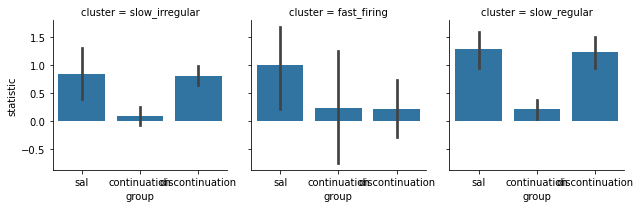

In [79]:
(
    res
    .merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
    .pipe(sns.FacetGrid, col="cluster")
    .map(sns.barplot, "group", "statistic")
)


In [1]:
from citalopram_project.correlations import pairwise_correlation_spikes, pairwise_correlation, shuffled_isi_correlation_test
from citalopram_project.transforms import  bin_spikes_interval, pivot, gaussian_smooth
from citalopram_project.load import load_spikes, load_neurons
from citalopram_project.compose import Pipeline

neurons = load_neurons()
chal_spikes = load_spikes("chal").merge(neurons[["neuron_id", "cluster", "session_name", "group"]]).loc[lambda x: x.spiketimes <= 1200]
df1 = chal_spikes.loc[lambda x: x.session_name == neurons.session_name.unique()[5]]

In [4]:
res = shuffled_isi_correlation_test(df1, n_boot=10, bin_width=1, fillna=0, sigma=0.1, show_progress=True)

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


In [8]:
(res.p_adj < 0.05).mean()

0.6428571428571429